# 반려동물 근골격계 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random
from PIL import Image
import glob
import json

import torch
import torchvision.transforms as T
import timm

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

# Custom Dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        self.img_path = os.path.join(root_dir, 'images')

        img_list = os.listdir(self.img_path)
        for img in img_list:
            annotation_root_path = os.path.join(root_dir, 'annotations')
            annotation_path = os.path.join(annotation_root_path, img.replace('.jpg', '.json'))
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)
            disease = annotation.get('metadata', [{}]).get('Disease-Name', None)
            label = classes.index(disease)

            self.data.append((img, label))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_path, self.data[idx][0])).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [5]:
classes = ['Mu03', 'Mu05', 'Mu06', 'Mu07']

transforms = T.Compose([
    T.ToTensor(),
    T.Resize((112, 112))
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/3/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/3/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/3/data/test', classes, transforms)

In [6]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

3421 1569 652


In [7]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# train, eval

In [8]:
def training(model, trian_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    total_preds = []
    total_labels = []
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (labels == preds).sum().item()

        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_accuracy, train_f1

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    total_labels = []
    total_preds = []
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_accuracy, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    total_train_loss = []
    total_train_accuracy = []
    total_train_f1 = []
    total_valid_loss = []
    total_valid_accuracy = []
    total_valid_f1 = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy, train_f1 = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy, valid_f1 = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        total_train_loss.append(train_loss)
        total_train_accuracy.append(train_accuracy)
        total_train_f1.append(train_f1)
        total_valid_loss.append(valid_loss)
        total_valid_accuracy.append(valid_loss)
        total_valid_f1.append(valid_f1)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Train F1: {train_f1}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}, Valid F1: {valid_f1}')

    return model, total_train_loss, total_train_accuracy, total_train_f1, total_valid_loss, total_valid_accuracy, total_valid_f1

In [9]:
model = timm.create_model(
    'resnet18',
    num_classes = len(classes),
    pretrained=True
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, total_train_loss, total_train_accuracy, total_train_f1, total_valid_loss, total_valid_accuracy, total_valid_f1 = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 3)

  0%|          | 0/35 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 0.3808059460749584, Train Accuracy: 0.8754750073078047, Train F1: 0.8522062698565069
Valid Loss: 0.3543931944295764, Valid Accuracy: 0.7992351816443595, Valid F1: 0.6252662622427212


  0%|          | 0/35 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 0.08471077749771731, Train Accuracy: 0.9672610347851506, Train F1: 0.960907482689423
Valid Loss: 0.23574817273765802, Valid Accuracy: 0.8789037603569152, Valid F1: 0.6862078272505565


  0%|          | 0/35 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 0.05611642333013671, Train Accuracy: 0.9809997076878105, Train F1: 0.9774920870458733
Valid Loss: 0.0949860168620944, Valid Accuracy: 0.9725940089228808, Valid F1: 0.7373258420335749


# test

In [11]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())
        

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
f1_score(total_labels, total_preds, average='macro')

0.9839172238820126

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


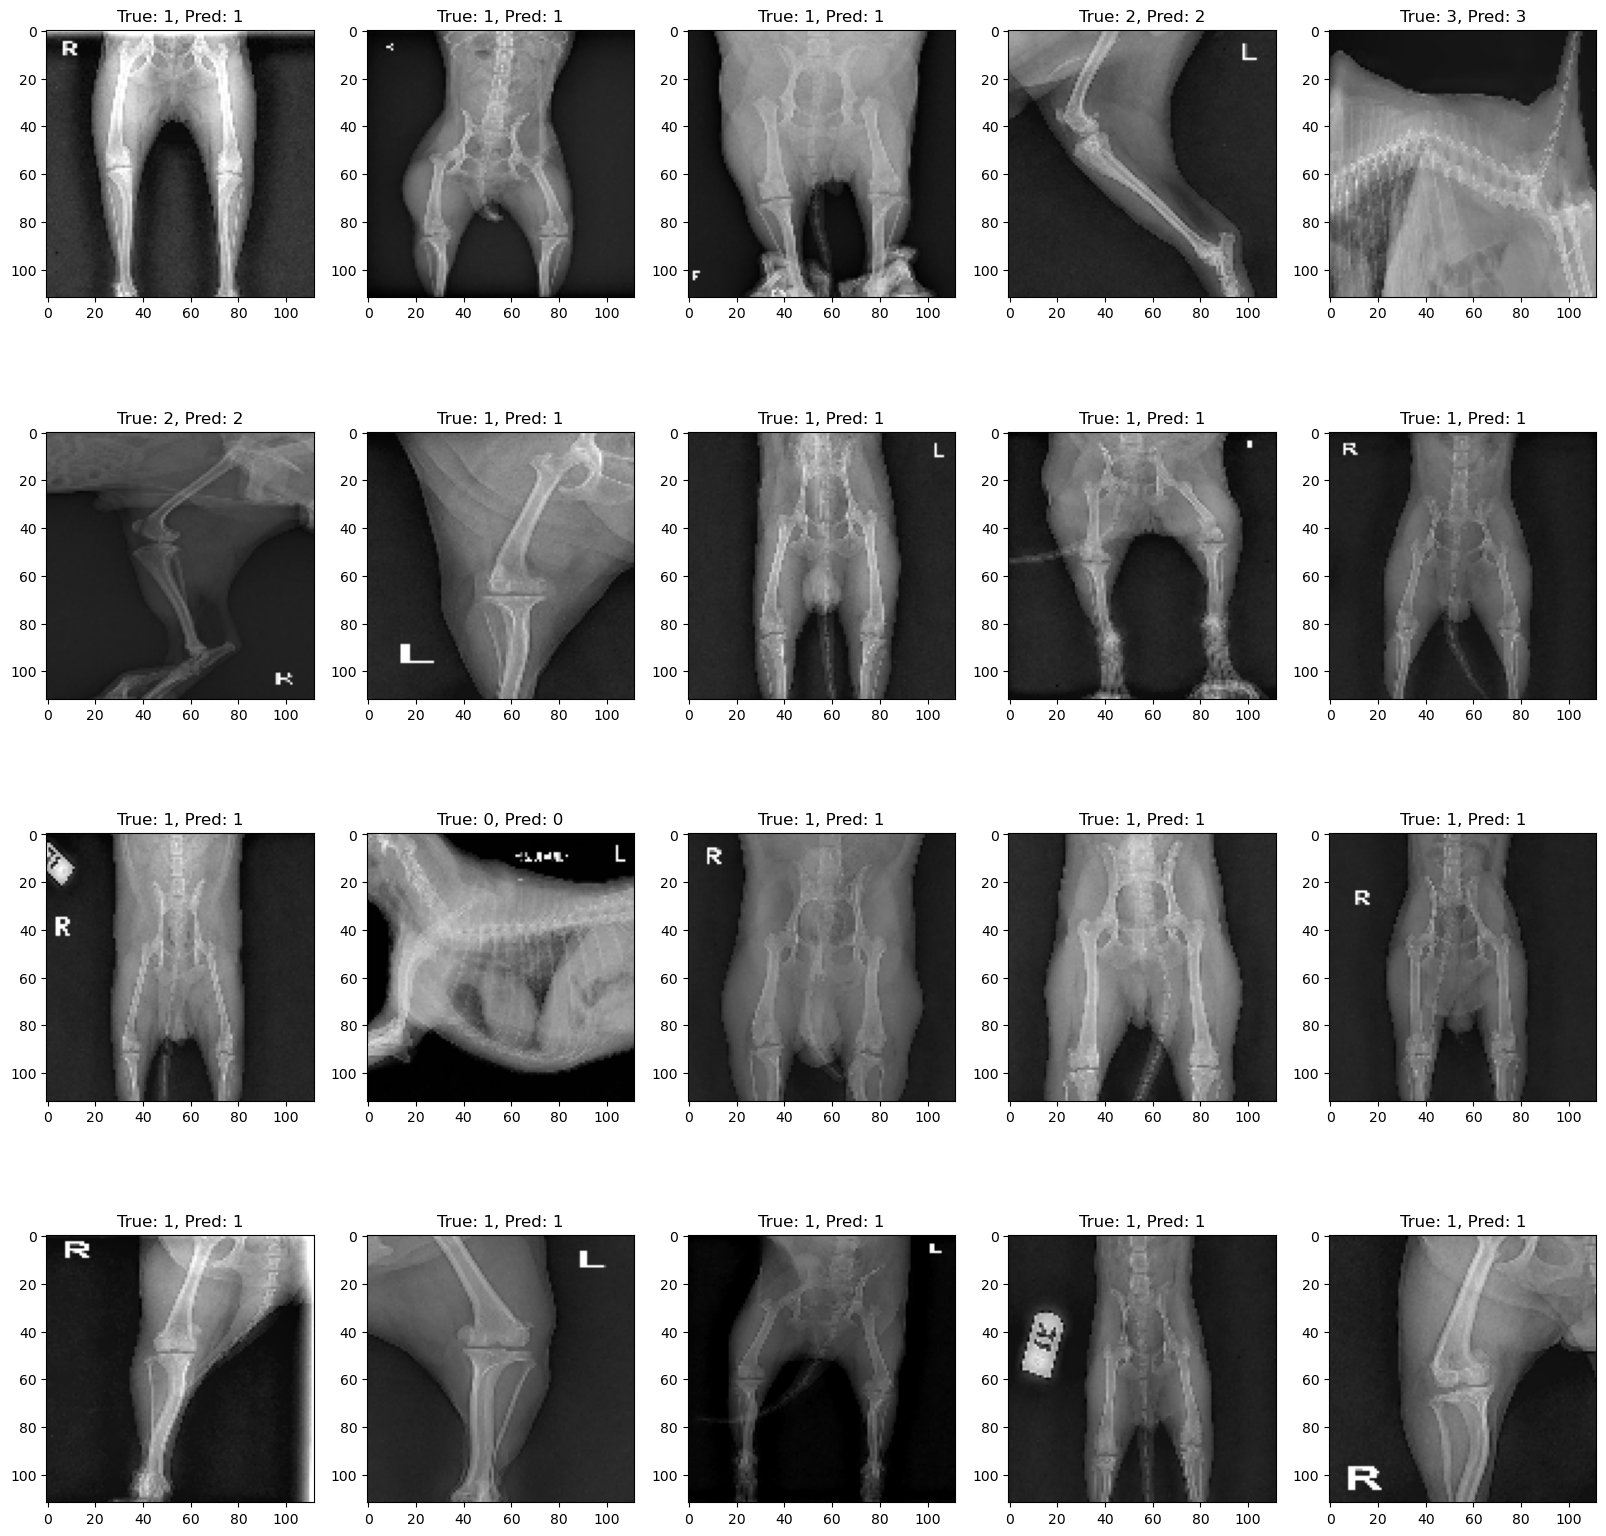

In [14]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {test_dataset[i][1]}, Pred: {total_preds[i]}')